In [88]:
import os
import torch
import numpy as np
import torch.nn as nn
import gymnasium as gym
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

seed = 2024
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)

discount_factor = 0.99
num_episodes = 1000
learning_rate = 0.001
hidden_size = 16

In [89]:
class PolicyWithBaselineNetwork(torch.nn.Module):
    def __init__(self, input_size, hidden_size, action_size):
        super().__init__()

        self.policy_fc1 = nn.Linear(input_size, hidden_size)
        self.policy_fc2 = nn.Linear(hidden_size, action_size)
        self.relu = nn.ReLU()

        self.value_fc1 = nn.Linear(input_size, hidden_size)
        self.value_fc2 = nn.Linear(hidden_size, 1)

    def forward(self, x):
        policy = self.policy_fc1(x)
        policy = self.relu(policy)
        policy = self.policy_fc2(policy)

        value = self.value_fc1(x)
        value = self.relu(value)
        value = self.value_fc2(value)

        return policy, value

In [90]:
def preprocess_state(state):
    normalized_state = torch.as_tensor(state, dtype=torch.float32, device=device)

    return normalized_state

In [91]:
def compute_returns(rewards):
    returns = []
    R = 0
    for r in reversed(rewards):
        R = r + discount_factor * R
        returns.insert(0, R)
    return returns

In [103]:
def plot_training_results(rewards, policy_losses, value_losses):
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 8))

    ax1.plot(rewards)
    ax1.set_xlabel('Time Step')
    ax1.set_ylabel('Reward')
    ax1.set_title('Training Rewards')
    ax1.grid(True)

    ax2.plot(policy_losses, label='Policy Loss')
    ax2.set_xlabel('Time Step')
    ax2.set_ylabel('Policy Loss')
    ax2.set_title('Training Losses')
    ax2.grid(True)

    ax3.plot(value_losses, label='Value Loss', color='orange')
    ax3.set_xlabel('Time Step')
    ax3.set_ylabel('Value Loss')
    ax3.set_title('Training Losses')
    ax3.grid(True)

    plt.tight_layout()
    plt.show()


def test_and_create_gif(policy, gif_filename='cartpole_test.gif'):
    test_env = gym.make("CartPole-v1", max_episode_steps=500, render_mode="rgb_array")
    test_env = gym.wrappers.NormalizeObservation(test_env)

    frames = []
    total_reward = 0

    state, _ = test_env.reset(seed=seed)
    done = False
    truncation = False

    print("Testing trained policy and creating GIF...")

    while not done and not truncation:
        frame = test_env.render()
        frames.append(Image.fromarray(frame))

        state_tensor = preprocess_state(state)
        action_probs, value = policy(state_tensor)
        action = torch.argmax(action_probs, dim=0).item()

        state, reward, done, truncation, _ = test_env.step(action)
        total_reward += reward

    test_env.close()

    if frames:
        frames[0].save(
            gif_filename,
            save_all=True,
            append_images=frames[1:],
            duration=50,  # 50ms per frame
            loop=0
        )
        print(f"GIF saved as '{gif_filename}' with {len(frames)} frames")
        print(f"Test episode reward: {total_reward}")
    else:
        print("No frames captured for GIF")

In [ ]:
# make function to compute action distribution
def get_policy(obs, logits_net):
    logits, value = logits_net(obs)
    return torch.distributions.Categorical(logits=logits), value

# make action selection function (outputs int actions, sampled from policy)
def get_action(obs, logits_net):
    policy, value = get_policy(obs, logits_net)
    return policy.sample().item(), value

def train(env, batch_size=500, epochs=1000):

    obs_dim = env.observation_space.shape[0]
    n_acts = env.action_space.n

    # make core of policy network
    logits_net = PolicyWithBaselineNetwork(input_size=obs_dim, hidden_size=hidden_size, action_size=n_acts).to(device)

    # make loss function whose gradient, for the right data, is policy gradient
    def compute_loss(obs, act, weights):
        # Normalise weights
        weights = (weights - weights.mean()) / (weights.std() + 1e-8)
        logp = get_policy(obs, logits_net)[0].log_prob(act)
        return -(logp * weights).mean()

    compute_value_loss = nn.MSELoss()

    # make optimizer
    optimizer = torch.optim.Adam(logits_net.parameters(), lr=learning_rate)

    # collect data for plot_training_results
    rewards = []
    policy_losses = []
    value_losses = []

    # for training policy
    def train_one_epoch():
        # make some empty lists for logging.
        batch_obs = []          # for observations
        batch_acts = []         # for actions
        batch_weights = []      # for R(tau) weighting in policy gradient
        batch_vals = []

        # reset episode-specific variables
        obs, _ = env.reset()       # first obs comes from starting distribution
        done = False            # signal from environment that episode is over
        ep_rews = []            # list for rewards accrued throughout ep

        # collect experience by acting in the environment with current policy
        while True:
            # save obs
            batch_obs.append(obs.copy())

            # act in the environment
            obs = np.asarray(obs, dtype=np.float32)  # Ensure obs is a numpy array
            act, val = get_action(torch.as_tensor(obs, dtype=torch.float32).to(device), logits_net)
            obs, rew, done, truncation, _ = env.step(act)

            # save action, reward
            batch_acts.append(act)
            ep_rews.append(rew)
            batch_vals.append(val)

            if done or truncation:
                batch_weights.extend(compute_returns(ep_rews))

                # reset episode-specific variables
                obs, _ = env.reset()
                done, ep_rews = False, []

                # end experience loop if we have enough of it
                if len(batch_obs) > batch_size:
                    break

        # take a single combined policy/value gradient update step
        optimizer.zero_grad()

        batch_weights_tensor = torch.as_tensor(batch_weights, dtype=torch.float32).to(device)
        batch_values_tensor = torch.as_tensor(batch_vals, dtype=torch.float32).to(device)

        batch_obs = np.array(batch_obs, dtype=np.float32)
        batch_loss_policy = compute_loss(obs=torch.as_tensor(batch_obs, dtype=torch.float32).to(device),
                                  act=torch.as_tensor(batch_acts, dtype=torch.int32).to(device),
                                  weights=batch_weights_tensor - batch_values_tensor
                                  )
        batch_weights_tensor = (batch_weights_tensor - batch_weights_tensor.mean()) / (batch_weights_tensor.std() + 1e-8)
        batch_values_tensor = (batch_values_tensor - batch_values_tensor.mean()) / (batch_values_tensor.std() + 1e-8)

        batch_loss_value = compute_value_loss(
            input=batch_weights_tensor,
            target=batch_values_tensor
        )

        batch_loss = batch_loss_policy + batch_loss_value

        batch_loss.backward()
        optimizer.step()
        return batch_loss_policy, batch_loss_value, batch_weights

    for i in tqdm(range(epochs)):
        batch_loss_policy, batch_loss_value, batch_weights = train_one_epoch()
        rewards += batch_weights
        policy_losses += [batch_loss_policy.item()] * len(batch_weights)
        value_losses += [batch_loss_value.item()] * len(batch_weights)

    return rewards, policy_losses, value_losses, logits_net

In [94]:
# Create environment for training (no rendering)
env = gym.make("CartPole-v1", max_episode_steps=500)
env = gym.wrappers.NormalizeObservation(env)
env.action_space.seed(seed)

print("Starting REINFORCE training...")
rewards, policy_losses, value_losses, logits_net = train(env, epochs=num_episodes)


Starting REINFORCE training...


100%|██████████| 1000/1000 [02:36<00:00,  6.39it/s]


In [95]:
env.close()

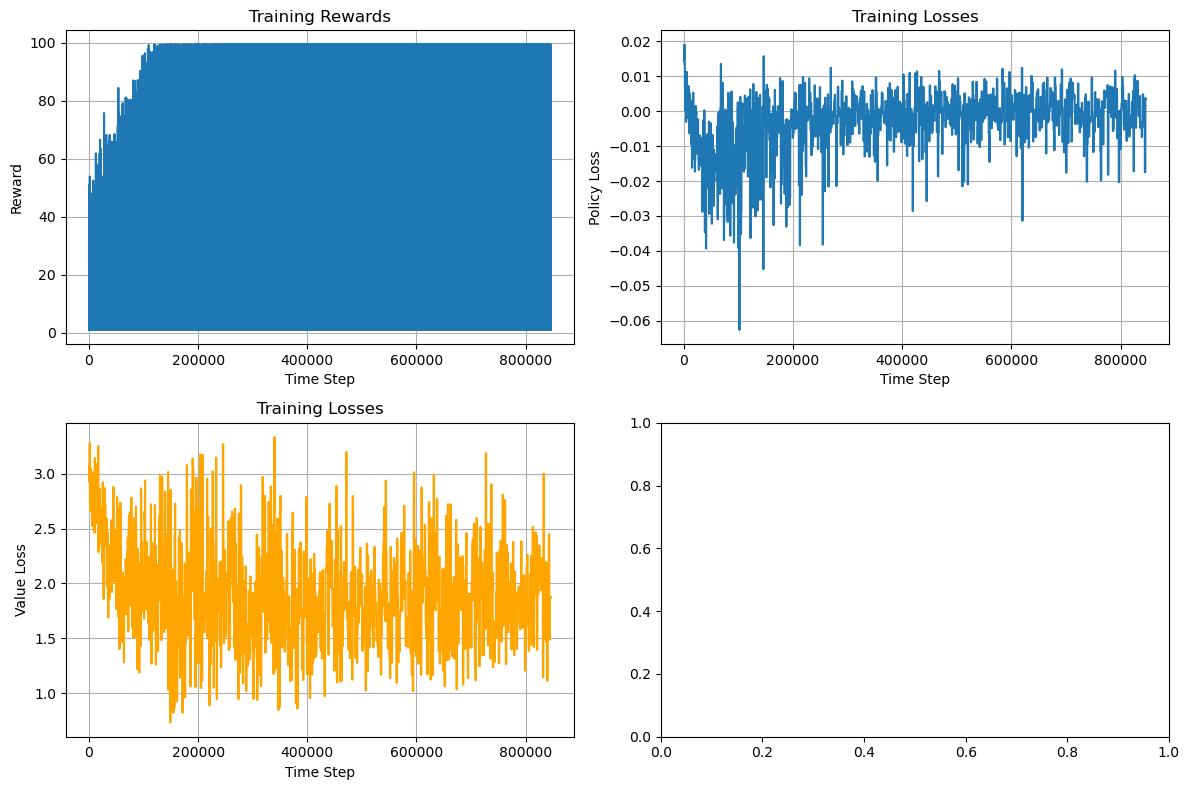

In [100]:
plot_training_results(rewards, policy_losses, value_losses)

In [111]:
def test(logits_net, num_episodes):
    rewards = []
    for i in range(num_episodes):
        obs, _ = env.reset()
        done = False
        truncation = False
        total_reward = 0
        while not done and not truncation:
            action, value = get_action(torch.as_tensor(obs, dtype=torch.float32).to(device), logits_net)
            obs, reward, done, truncation, _ = env.step(action)
            total_reward += reward
        print(f"Episode {i+1}: Total Reward: {total_reward}")
        rewards.append(total_reward)
    return rewards

In [118]:
test_rewards = test(logits_net, 20)

Episode 1: Total Reward: 500.0
Episode 2: Total Reward: 500.0
Episode 3: Total Reward: 500.0
Episode 4: Total Reward: 500.0
Episode 5: Total Reward: 500.0
Episode 6: Total Reward: 500.0
Episode 7: Total Reward: 500.0
Episode 8: Total Reward: 500.0
Episode 9: Total Reward: 500.0
Episode 10: Total Reward: 500.0
Episode 11: Total Reward: 500.0
Episode 12: Total Reward: 500.0
Episode 13: Total Reward: 500.0
Episode 14: Total Reward: 500.0
Episode 15: Total Reward: 500.0
Episode 16: Total Reward: 500.0
Episode 17: Total Reward: 500.0
Episode 18: Total Reward: 500.0
Episode 19: Total Reward: 500.0
Episode 20: Total Reward: 500.0


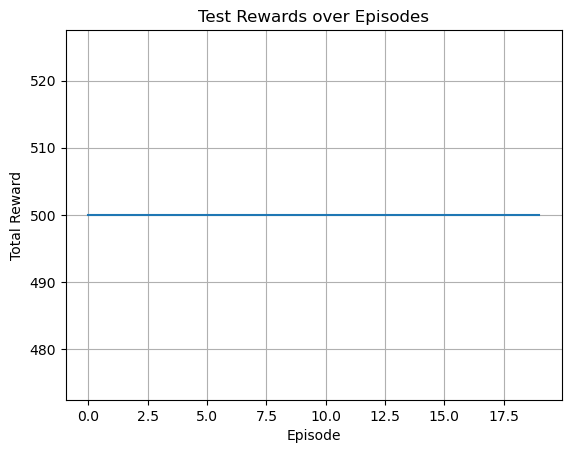

In [119]:
plt.plot(test_rewards, label='Test Rewards')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Test Rewards over Episodes')
plt.grid(True)
plt.show()

In [120]:
test_and_create_gif(logits_net, gif_filename='cartpole_test.gif')

Testing trained policy and creating GIF...
GIF saved as 'cartpole_test.gif' with 500 frames
Test episode reward: 500.0
